In [1]:
import argparse
import logging
import time

import torch
import torchtext
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.prototype.transforms import load_sp_model, PRETRAINED_SP_MODEL, SentencePieceTokenizer
from torchtext.utils import download_from_url
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchtext.vocab import GloVe, FastText
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np
import random
from sentence_transformers import SentenceTransformer

In [22]:
# EXPERIMENT SETTING

# embedding method
EMBD = 'sbert' # choose from 'GloVe' or 'sbert'
# number of classification class - according to different Data Set
NUM_CLASS = 4
# Corruption: if not then concatnate
INSERT = True 

## About Data Set

AG News (AG’s News Corpus) is a subdataset of AG's corpus of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus.

## Tokenizer
- Different models tolenize in different ways. 
    - Word2Vec / GloVe does words (WordLevel).
    - BERT does WordPiece.
    - The original transformer did BytePairEncoding.
    - FastText uses n-grams.


In [3]:
TOKENIZER = get_tokenizer("basic_english")

## Embedding: GloVE/sbert

In [4]:
# GloVe
GLOVE = GloVe(name='840B', dim=300)
#([6, 300])
GLOVE.get_vecs_by_tokens(TOKENIZER("Hello, How are you?"), lower_case_backup=True) 


# FASTTEXT = FastText()

# sbert
model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']
embeddings = model.encode(sentences) #([3, 384])

# Forward-Forward Algo

## Dataset - get Positive Samples & Negative Samples

In [5]:
# define collate_fn with embedding method
def vectorize_batch(batch, embed_method = 'GloVe'):
    Y, X = list(zip(*batch))
    
    if embed_method == 'GloVe':
      X = [TOKENIZER(x) for x in X]
      X_tensor = torch.zeros(len(batch), 300)
      for i, tokens in enumerate(X):
          X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
    
    if embed_method == 'sbert': #slow
      X_tensor = torch.from_numpy(model.encode(X))

    return X_tensor, torch.tensor(Y) - 1 

In [6]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# torch.Size([114000, embed]) torch.Size([114000])
train_loader = DataLoader(split_train_, batch_size=len(split_train_), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

# torch.Size([6000, embed]) torch.Size([6000])
valid_loader = DataLoader(split_valid_, batch_size=len(split_valid_), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

# torch.Size([7600, embed]) torch.Size([7600])
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

In [8]:
x_train, y = next(iter(train_loader))
x_train.shape, y.shape

(torch.Size([114000, 384]), torch.Size([114000]))

In [21]:
x_train[:5,:],y[:5]

(tensor([[-0.0085, -0.0383, -0.0450,  ..., -0.0229,  0.0694, -0.0535],
         [-0.0284,  0.0183,  0.0259,  ...,  0.0785,  0.0022,  0.0653],
         [-0.0056,  0.0167, -0.0353,  ..., -0.0398,  0.0563, -0.0297],
         [ 0.0237,  0.0073,  0.0410,  ..., -0.0009,  0.0957,  0.0462],
         [-0.0450,  0.0229, -0.0039,  ...,  0.0649, -0.0544,  0.0254]]),
 tensor([2, 3, 1, 3, 3]))

In [23]:
def create_pos_neg(x_train, insert = True):
  
  x_pos = x_train.clone().detach()
  x_neg = x_train.clone().detach()

  # if concatenate
  if not insert:
    x_pos = torch.cat((torch.zeros(x_pos.size(0), NUM_CLASS), x_pos), 1)
    x_neg = torch.cat((torch.zeros(x_neg.size(0), NUM_CLASS), x_neg), 1)
  # if insert
  else:
    x_pos[:,0:NUM_CLASS] = torch.zeros(x_pos.size(0), NUM_CLASS)
    x_neg[:,0:NUM_CLASS] = torch.zeros(x_neg.size(0), NUM_CLASS)

  y_ = torch.randint(0,NUM_CLASS,(x_neg.size(0),))

  for i in range(x_neg.size(0)):
    x_pos[i,y[i]] = 1
    # x_neg[i,y_[i]] = 1
    # # NOTE: y_[i] maybe the right label, which will certainly hurt experiment results!
    if y_[i] != y[i]:
      x_neg[i,y_[i]] = 1
    else:
      x_neg[i,(y[i]+1)%NUM_CLASS] = 1
  
  return x_pos, x_neg

In [24]:
x_pos, x_neg = create_pos_neg(x_train, insert=INSERT)
embed_len = x_pos.shape[1]
embed_len

384

In [25]:
print(x_pos[:5,:])
print(x_neg[:5,:])

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ..., -2.2917e-02,
          6.9381e-02, -5.3504e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  7.8489e-02,
          2.2386e-03,  6.5333e-02],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ..., -3.9760e-02,
          5.6342e-02, -2.9695e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.6235e-04,
          9.5728e-02,  4.6200e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.4903e-02,
         -5.4402e-02,  2.5405e-02]])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.2917e-02,
          6.9381e-02, -5.3504e-02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ...,  7.8489e-02,
          2.2386e-03,  6.5333e-02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ..., -3.9760e-02,
          5.6342e-02, -2.9695e-02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ..., -8.6235e-04,
          9.5728e-02,  4.6200e-02],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  6.4903e-02,
     

## Model

In [26]:
layer_epoch = 1000
layer_threshold = 5  #2.0

class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = layer_threshold
        self.num_epochs = layer_epoch

    def forward(self, x):
        x_direction = x / (x.norm(p = 2, dim = 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            # torch.Size([114000, embed]) --> torch.Size([114000])
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.

            # after exp()  torch.Size([228000])
            # loss torch.size([1])
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()

            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()

            if i % 100 == 0 and i > 0:
              print(
                "| epoch {:3d} | loss {:8.3f}".format(i, loss)
              )
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [27]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]
        print(self.layers)

    def predict(self, x):
        goodness_per_label = []
        for label in range(NUM_CLASS):
            h = x.clone().detach()
            if INSERT:
              h[:, 0:NUM_CLASS] = torch.zeros(x.size(0), NUM_CLASS)
            else:
              h = torch.cat((torch.zeros(x.size(0), NUM_CLASS), h), dim = 1)
            h[:, label] = 1      
            # 4 , x.size(0)      
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]

            goodness_per_label += [sum(goodness).unsqueeze(1)]
        # [torch(x.size(0)),torch(x.size(0)),torch(x.size(0)),torch(x.size(0))]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        # print(goodness_per_label.shape)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print("-" * 59)
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)
            print("-" * 59)

## Train the model

In [28]:
net = Net([embed_len, 256, 128, 64, len(target_classes)])
net.train(x_pos, x_neg)

[Layer(
  in_features=384, out_features=256, bias=True
  (relu): ReLU()
), Layer(
  in_features=256, out_features=128, bias=True
  (relu): ReLU()
), Layer(
  in_features=128, out_features=64, bias=True
  (relu): ReLU()
), Layer(
  in_features=64, out_features=4, bias=True
  (relu): ReLU()
)]
-----------------------------------------------------------
training layer 0 ...


 10%|█         | 101/1000 [01:17<11:56,  1.25it/s]

| epoch 100 | loss    0.472


 20%|██        | 201/1000 [02:34<10:08,  1.31it/s]

| epoch 200 | loss    0.283


 30%|███       | 301/1000 [03:50<08:37,  1.35it/s]

| epoch 300 | loss    0.234


 40%|████      | 401/1000 [05:05<07:27,  1.34it/s]

| epoch 400 | loss    0.214


 50%|█████     | 501/1000 [06:19<06:13,  1.34it/s]

| epoch 500 | loss    0.203


 60%|██████    | 601/1000 [07:33<04:56,  1.34it/s]

| epoch 600 | loss    0.195


 70%|███████   | 701/1000 [08:48<03:42,  1.34it/s]

| epoch 700 | loss    0.190


 80%|████████  | 801/1000 [10:03<02:27,  1.34it/s]

| epoch 800 | loss    0.185


 90%|█████████ | 901/1000 [11:18<01:16,  1.30it/s]

| epoch 900 | loss    0.182


100%|██████████| 1000/1000 [12:32<00:00,  1.33it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 1 ...


 10%|█         | 101/1000 [00:27<04:04,  3.67it/s]

| epoch 100 | loss    0.445


 20%|██        | 201/1000 [00:55<03:43,  3.58it/s]

| epoch 200 | loss    0.327


 30%|███       | 301/1000 [01:22<03:12,  3.63it/s]

| epoch 300 | loss    0.301


 40%|████      | 401/1000 [01:49<02:44,  3.64it/s]

| epoch 400 | loss    0.287


 50%|█████     | 501/1000 [02:17<02:16,  3.64it/s]

| epoch 500 | loss    0.276


 60%|██████    | 601/1000 [02:44<01:51,  3.59it/s]

| epoch 600 | loss    0.266


 70%|███████   | 701/1000 [03:12<01:21,  3.69it/s]

| epoch 700 | loss    0.259


 80%|████████  | 801/1000 [03:39<00:54,  3.62it/s]

| epoch 800 | loss    0.253


 90%|█████████ | 901/1000 [04:06<00:26,  3.67it/s]

| epoch 900 | loss    0.248


100%|██████████| 1000/1000 [04:34<00:00,  3.65it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 2 ...


 10%|█         | 102/1000 [00:11<01:39,  9.01it/s]

| epoch 100 | loss    0.419


 20%|██        | 202/1000 [00:22<01:27,  9.09it/s]

| epoch 200 | loss    0.410


 30%|███       | 302/1000 [00:33<01:18,  8.88it/s]

| epoch 300 | loss    0.404


 40%|████      | 402/1000 [00:44<01:07,  8.90it/s]

| epoch 400 | loss    0.399


 50%|█████     | 502/1000 [00:56<00:56,  8.86it/s]

| epoch 500 | loss    0.394


 60%|██████    | 602/1000 [01:07<00:44,  8.88it/s]

| epoch 600 | loss    0.389


 70%|███████   | 702/1000 [01:18<00:33,  8.99it/s]

| epoch 700 | loss    0.384


 80%|████████  | 802/1000 [01:29<00:21,  9.06it/s]

| epoch 800 | loss    0.379


 90%|█████████ | 902/1000 [01:40<00:11,  8.84it/s]

| epoch 900 | loss    0.375


100%|██████████| 1000/1000 [01:51<00:00,  8.94it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 3 ...


 11%|█         | 107/1000 [00:02<00:22, 39.32it/s]

| epoch 100 | loss    0.559


 21%|██        | 208/1000 [00:05<00:20, 38.91it/s]

| epoch 200 | loss    0.553


 31%|███       | 307/1000 [00:07<00:17, 40.22it/s]

| epoch 300 | loss    0.549


 41%|████      | 409/1000 [00:10<00:14, 40.06it/s]

| epoch 400 | loss    0.545


 51%|█████     | 508/1000 [00:12<00:12, 38.11it/s]

| epoch 500 | loss    0.541


 61%|██████    | 606/1000 [00:15<00:10, 39.17it/s]

| epoch 600 | loss    0.538


 71%|███████   | 709/1000 [00:18<00:07, 39.30it/s]

| epoch 700 | loss    0.536


 81%|████████  | 808/1000 [00:20<00:04, 40.30it/s]

| epoch 800 | loss    0.534


 91%|█████████ | 909/1000 [00:23<00:02, 40.66it/s]

| epoch 900 | loss    0.532


100%|██████████| 1000/1000 [00:25<00:00, 39.41it/s]

-----------------------------------------------------------


In [29]:
print('train acc:', net.predict(x_train).eq(y).float().mean().item())

train acc: 0.8908859491348267


## Prediction

In [17]:
x_test, Y_actual = next(iter(train_loader))

In [30]:
Y_preds = net.predict(x_test)

In [31]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8908859649122807

Classification Report : 
              precision    recall  f1-score   support

       World       0.91      0.87      0.89     28524
      Sports       0.95      0.98      0.96     28460
    Business       0.83      0.87      0.85     28484
    Sci/Tech       0.88      0.84      0.86     28532

    accuracy                           0.89    114000
   macro avg       0.89      0.89      0.89    114000
weighted avg       0.89      0.89      0.89    114000


Confusion Matrix : 
[[24863   967  1757   937]
 [  276 27819   241   124]
 [ 1012   315 24872  2285]
 [ 1130   270  3125 24007]]


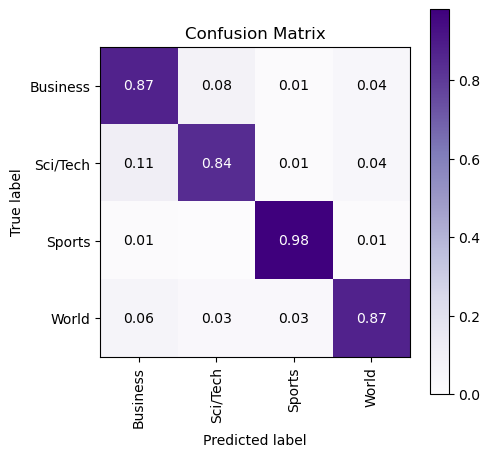

In [32]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

# Baseline

## Dataset

In [33]:
# define collate_fn with embedding method
def vectorize_batch(batch, embed_method = 'GloVe'):
    Y, X = list(zip(*batch))
    
    if embed_method == 'GloVe':
      X = [TOKENIZER(x) for x in X]
      X_tensor = torch.zeros(len(batch), 300)
      for i, tokens in enumerate(X):
          X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
    
    if embed_method == 'sbert': #slow
      X_tensor = torch.from_numpy(model.encode(X))

    return X_tensor, torch.tensor(Y) - 1 


target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))
valid_loader = DataLoader(split_valid_, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))
test_loader = DataLoader(test_dataset, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

In [34]:
for X, Y in train_loader:
    print(X)
    print(X.shape, Y.shape)
    break

tensor([[-0.0392, -0.0100,  0.0684,  ..., -0.0276,  0.0965,  0.0333],
        [ 0.0495, -0.0154,  0.0361,  ..., -0.0552, -0.0461,  0.0081],
        [-0.0362,  0.0796, -0.0032,  ..., -0.0031, -0.0029, -0.0228],
        ...,
        [ 0.0253,  0.0465,  0.0059,  ...,  0.0044, -0.0422, -0.0239],
        [ 0.0213, -0.0229, -0.0260,  ..., -0.0480, -0.0013, -0.0083],
        [ 0.0164,  0.0112,  0.0062,  ..., -0.1177, -0.0115, -0.0318]])
torch.Size([1024, 384]) torch.Size([1024])


In [35]:
embed_len = X.shape[1]
embed_len

384

## Model

In [36]:
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

## Train the model

In [37]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))

In [38]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            # X: Batch_size x (25*300)
            # Y: Batch_size x 1
            # Y_preds: Batch_size x num_class
            Y_preds = model(X) 

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i%5==0:
            print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
            print("Train Acc  : {:.3f}".format(accuracy_score(Y.numpy(), Y_preds.argmax(dim=-1).numpy())))
            CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [39]:
epochs = 25
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

  9%|▉         | 10/112 [02:34<26:18, 15.48s/it]


KeyboardInterrupt: 

## Prediction

In [ ]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

In [ ]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9156578947368421

Classification Report : 
              precision    recall  f1-score   support

       World       0.93      0.92      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.92      0.83      0.87      1900
    Sci/Tech       0.86      0.93      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600


Confusion Matrix : 
[[1746   45   60   49]
 [  18 1861   13    8]
 [  82   13 1581  224]
 [  40   18   71 1771]]


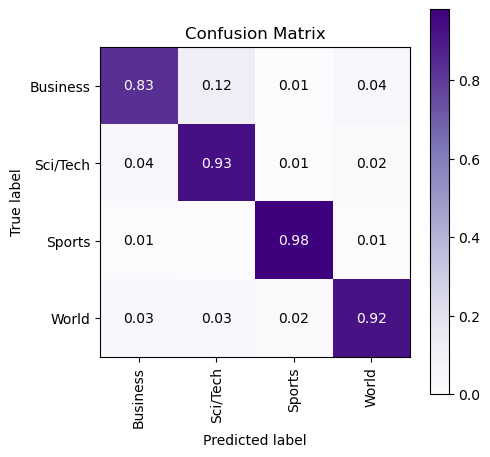

In [ ]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);